## This notebook act as a template that does all of the loading data work
## using *Dataset* and *Dataloader* library from Pytorch
## to provide a ready-to-train dataloader include:
- train_loader
- valid_loader
- test_loader


In [20]:
import pandas as pd
import numpy as np
from google.colab import drive

import cv2

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from PIL import Image
import os

In [21]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
base_dataset_path = '/content/drive/MyDrive/Image_Processing_Manhole_Dataset'
subfolders = ['train', 'valid', 'test']

In [23]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [24]:
# --- Step 1: Create a custom Dataset class ---
# This class handles loading the image paths and labels from the CSV file.
class MyImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and the classes CSV.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

        # Load the CSV file containing image filenames and their corresponding class labels.
        classes_csv_path = os.path.join(self.root_dir, '_classes.csv')
        self.labels_df = pd.read_csv(classes_csv_path)

        # Create a mapping from class names (e.g., 'yes', 'no') to integer labels (e.g., 0, 1)
        self.classes = sorted(self.labels_df[' closed manhole'].unique())
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        print(f"Loaded classes: {self.classes}")
        print(f"Class to index mapping: {self.class_to_idx}")

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the filename and class from the dataframe at the given index
        img_name = self.labels_df.iloc[idx, 0]
        class_name = self.labels_df.iloc[idx, 1]

        # Construct the full image path
        img_path = os.path.join(self.root_dir, img_name)

        # Open the image file
        image = Image.open(img_path).convert('RGB')

        # Get the integer label
        label = self.class_to_idx[class_name]

        # Apply transformations if they were provided
        if self.transform:
            image = self.transform(image)

        return image, label

# --- Step 2: Define the path to your dataset and transformations ---
# Make sure your folder structure is like this:
#
# your_project_folder/
# ├── train/
# │   ├── __classes.csv
# │   └── image_files...
# ├── valid/
# │   ├── __classes.csv
# │   └── image_files...
# └── test/
#     ├── __classes.csv
#     └── image_files...



transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# --- Step 3: Create Dataset instances for each split ---
try:
    train_dataset = MyImageDataset(root_dir=os.path.join(base_dataset_path, 'train'), transform=transform)
    valid_dataset = MyImageDataset(root_dir=os.path.join(base_dataset_path, 'valid'), transform=transform)
    test_dataset = MyImageDataset(root_dir=os.path.join(base_dataset_path, 'test'), transform=transform)

    print("\nDatasets created successfully for all splits!")
    print(f"Training set size: {len(train_dataset)} images")
    print(f"Validation set size: {len(valid_dataset)} images")
    print(f"Testing set size: {len(test_dataset)} images")

except FileNotFoundError as e:
    print(f"Error: A required directory or file was not found: {e}")
    print("Please check your path and folder structure.")

# --- Step 4: Create a DataLoader for each set ---
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Only train_dataset need to be shuffled
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- Step 5: Iterate through a DataLoader (optional demo) ---
print("\n--- Example of loading a batch from the training set ---")
train_images, train_labels = next(iter(train_loader))
print(f"Training images tensor shape: {train_images.shape}")
print(f"Training labels tensor shape: {train_labels.shape}")


Loaded classes: [np.int64(0), np.int64(1)]
Class to index mapping: {np.int64(0): 0, np.int64(1): 1}
Loaded classes: [np.int64(0), np.int64(1)]
Class to index mapping: {np.int64(0): 0, np.int64(1): 1}
Loaded classes: [np.int64(0), np.int64(1)]
Class to index mapping: {np.int64(0): 0, np.int64(1): 1}

Datasets created successfully for all splits!
Training set size: 1572 images
Validation set size: 455 images
Testing set size: 229 images

--- Example of loading a batch from the training set ---
Training images tensor shape: torch.Size([32, 3, 224, 224])
Training labels tensor shape: torch.Size([32])


Plot out some example from the dataloader

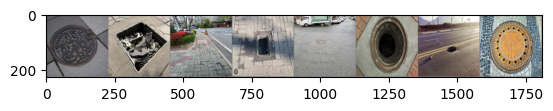

In [25]:
def imshow(img):
    img = img*0.5 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0))) # this code to make it from
                                                # (3,224,224) to (224,224,3)
    plt.show()

imshow(torchvision.utils.make_grid(train_images[:8]))  # do 8 image at a time

In [26]:
train_labels[:8]

tensor([1, 0, 1, 0, 1, 0, 0, 1])

## *Build model from here...*